#In questo notebook si allena nuovamente la rete che prende in input l'immagine e le feature con pyradiomics, ma in aggiunta si utilizza un dataset molto ampio di immagini DICOM le cui dimensioni delle singole immagini sono molto grandi. Dopo aver preparato i dati grazie ai codici allegati, si adottano strategie per non esaurire la ram disponibile. Per il fatto che colab hai dei limiti sulla memoria allocabile durante il training, le immagini vengono anche riscalate nel generatore.

Carichiamo i dati dal drive

In [2]:
!git clone https://github.com/Jake145/CAE-for-DM-segmentation

Cloning into 'CAE-for-DM-segmentation'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1132 (delta 8), reused 15 (delta 6), pack-reused 1112
Receiving objects: 100% (1132/1132), 1.20 GiB | 33.88 MiB/s, done.
Resolving deltas: 100% (499/499), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Helper functions

In [4]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 66kB/s 


In [5]:
% pip install CAE-Jake-HP-145

  Created wheel for CAE-Jake-HP-145: filename=CAE_Jake_HP_145-1.4-cp36-none-any.whl size=10829 sha256=5fba32f63268bd99ada9a4852a8010e50f86e3e1066bd7d2bc4cfe3ddc444205
  Stored in directory: /root/.cache/pip/wheels/ab/4c/de/8d6f04ed9811f61d750d0f6e36b7001bb097b89dfefe87c41b
Successfully built CAE-Jake-HP-145


# Import


In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from skimage.transform import resize
from skimage.io import imread
from functioncae import classes_cae, caehelper, cae_cnn_models
datapath='/content/drive/MyDrive'
maindir='Test2'
mass_train='Train_data'
mass_test='Test_data'
mask_train='Train_data_masks'
mask_test='Test_data_masks'
mask_train_res='resized_masks'
benign_label='BENIGN'
malign_label='MALIGNANT'
features_path='feats'

path_mass_tr=os.path.join(datapath,maindir,mass_train)
path_masks_resized=os.path.join(datapath,maindir,mask_train_res)




X_big_train,Y_big_train,Class_big_train=caehelper.read_dataset_big(path_mass_tr
    ,path_masks_resized,benign_label,malign_label)





#Carichiamo le features dal .csv

In [7]:
import pandas as pd

Pandatabigframe=pd.read_csv('/content/CAE-for-DM-segmentation/Pandatabigframe.csv')
#Pandata_big=pd.DataFrame(dataframe_big_train)

In [8]:
Pandatabigframe

,Unnamed: 0,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,...,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,Mass-Training_P_00009_RIGHT_MLO_MALIGNANT_1,0.747413,226.830157,240.709368,29284.5,169.535902,1192.170706,0.040710,29291.0,0.508845,9.411265,22695.040763,0.774813,0.135460,73.500427,16707.670395,163035.454850,1.427230,234579.983271,0.000107,0.000099,0.902852,146902.986886,0.000098,164272.034469,1.211831e+10,-1.276736e+07,64761.473513,626.826605,0.980811,19.657529,5.682069,235.179968,0.112117,0.051497,0.998607,0.971935,-0.346504,0.998891,0.053087,...,4.138706e+13,0.002509,1.044279e+07,72.132504,0.002505,16727.584700,162969.283451,1.052872,171813.231332,0.000102,0.000101,8.974453,27829.396127,0.966595,0.982930,0.017829,0.987207,160841.620990,0.000101,68.130425,0.002493,16794.473659,162765.336237,1.230220,201420.171924,0.000109,0.000105,23972.682207,0.877285,0.950186,154533.123875,0.000104,9.218375,0.932915,0.081230,0.003469,0.001150,1.895985e+06,1.061533,182.963476
1,Mass-Training_P_00015_LEFT_MLO_MALIGNANT_1,0.879908,244.257980,258.443417,40480.5,214.924671,1196.462120,0.029557,40488.0,0.596113,9.168308,32538.787888,0.803665,0.118911,125.602104,11446.811443,142006.697244,1.366430,195327.274303,0.000041,0.000037,0.916936,129947.331107,0.000036,142489.029616,8.745047e+09,2.186827e+06,44107.005955,948.254535,0.957894,24.262830,5.987544,353.664133,0.096540,0.042444,0.998789,

In [9]:
Pandatabigframe.sort_values(by='Unnamed: 0')

,Unnamed: 0,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,...,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
5,Mass-Training_P_00001_LEFT_CC_MALIGNANT_1,0.844456,438.527378,490.407993,120549.5,370.316873,3131.243000,0.025975,120561.0,0.393071,9.989785,97158.095412,0.805883,0.114843,189.830716,40739.724257,341696.582377,1.357097,468384.439976,0.000021,0.000019,0.918042,312773.291555,0.000018,342786.096581,5.005489e+10,-8.991204e+06,161279.939512,987.126563,0.987831,24.722411,6.015083,369.627113,0.094996,0.041401,0.999240,0.979004,-0.317632,0.998761,0.041726,...,1.628247e+14,0.001575,2.546217e+07,186.395482,0.001569,40747.020535,341518.601797,1.044101,357123.539733,0.000019,0.000019,9.591650,115489.344993,0.971844,0.985679,0.014822,0.989254,337714.161169,0.000019,176.482603,0.001551,40772.596380,341017.455498,1.189012,407890.571660,0.000021,0.000019,101911.656454,0.895683,0.958174,326280.793304,0.000019,9.811736,0.943763,0.066285,0.005103,0.000335,7.022677e+06,1.233332,141.196750
11,Mass-Training_P_00001_LEFT_MLO_MALIGNANT_1,0.948494,215.372212,255.313533,32195.0,204.279200,1208.722005,0.037544,32198.0,0.526227,9.350704,25298.681533,0.785722,0.130659,88.825766,16441.021103,202198.487235,1.406174,286928.205789,0.000044,0.000041,0.908237,182939.830030,0.000040,203168.790075,1.189493e+10,-1.125244e+07,63816.407375,785.673864,0.975660,22.071072,5.851098,293.085514,0.103679,0.046720,0.

In [10]:
Pandatabigframe.iloc[:,1:]

,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,...,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.747413,226.830157,240.709368,29284.5,169.535902,1192.170706,0.040710,29291.0,0.508845,9.411265,22695.040763,0.774813,0.135460,73.500427,16707.670395,163035.454850,1.427230,234579.983271,0.000107,0.000099,0.902852,146902.986886,0.000098,164272.034469,1.211831e+10,-1.276736e+07,64761.473513,626.826605,0.980811,19.657529,5.682069,235.179968,0.112117,0.051497,0.998607,0.971935,-0.346504,0.998891,0.053087,385.017115,...,4.138706e+13,0.002509,1.044279e+07,72.132504,0.002505,16727.584700,162969.283451,1.052872,171813.231332,0.000102,0.000101,8.974453,27829.396127,0.966595,0.982930,0.017829,0.987207,160841.620990,0.000101,68.130425,0.002493,16794.473659,162765.336237,1.230220,201420.171924,0.000109,0.000105,23972.682207,0.877285,0.950186,154533.123875,0.000104,9.218375,0.932915,0.081230,0.003469,0.001150,1.895985e+06,1.061533,182.963476
1,0.879908,244.257980,258.443417,40480.5,214.924671,1196.462120,0.029557,40488.0,0.596113,9.168308,32538.787888,0.803665,0.118911,125.602104,11446.811443,142006.697244,1.366430,195327.274303,0.000041,0.000037,0.916936,129947.331107,0.000036,142489.029616,8.745047e+09,2.186827e+06,44107.005955,948.254535,0.957894,24.262830,5.987544,353.664133,0.096540,0.042444,0.998789,0.973673,-0.290023,0.996652,0.042950,362.903991,...,5.958876

In [11]:
Pandatabigframe=Pandatabigframe.iloc[:,1:]

In [12]:
X_train_rad_big, X_test_rad_big, Y_train_rad_big, Y_test_rad_big,class_train_rad_big,class_test_rad_big,feature_train_big,feature_test_big = train_test_split(X_big_train, Y_big_train,Class_big_train,Pandatabigframe, test_size=0.2, random_state=42)

Ora che abbiamo tutte le feature, facciamo la pca

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
feature_train_bigg = sc.fit_transform(feature_train_big)
feature_test_bigg = sc.transform(feature_test_big)

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
feature_train_bigg = pca.fit_transform(feature_train_bigg)
feature_test_bigg = pca.transform(feature_test_bigg)
explained_variance_big = pca.explained_variance_ratio_


In [15]:
explained_variance_big

array([3.00424455e-01, 1.73479278e-01, 1.46650565e-01, 8.37611837e-02,
       6.05313406e-02, 4.20098585e-02, 4.03259492e-02, 2.92882671e-02,
       2.12383312e-02, 1.53545481e-02, 1.38667318e-02, 1.26923740e-02,
       1.04200553e-02, 8.71181141e-03, 6.26435352e-03, 5.72150735e-03,
       4.18571022e-03, 3.67298572e-03, 2.73872137e-03, 2.37850348e-03,
       2.17610882e-03, 1.94902424e-03, 1.61191121e-03, 1.27838479e-03,
       1.21802294e-03, 1.10199417e-03, 1.00005921e-03, 8.17870009e-04,
       6.76354335e-04, 5.77840462e-04, 4.98064161e-04, 4.83244609e-04,
       4.20925000e-04, 3.50653979e-04, 3.32586019e-04, 2.88426398e-04,
       2.59072639e-04, 2.06964667e-04, 1.77978288e-04, 1.62911804e-04,
       1.40763474e-04, 1.33721225e-04, 9.51080946e-05, 7.33134803e-05,
       4.26229669e-05, 3.44171231e-05, 3.11507970e-05, 2.62522097e-05,
       2.50457285e-05, 1.65197451e-05, 1.32331966e-05, 1.13073390e-05,
       1.02198709e-05, 7.98731115e-06, 6.23016051e-06, 5.19346780e-06,
      

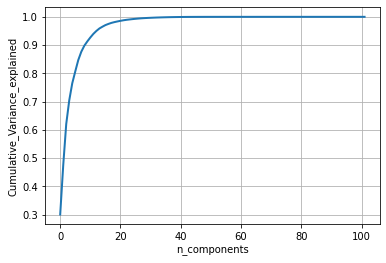

In [16]:
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot spettro dell pca   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

In [17]:
exp_var_cumsum=pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)  
for index,var in enumerate(exp_var_cumsum):  
    print('if n_components= %d,   variance=%f' %(index,np.round(var,3)))

if n_components= 0,   variance=30.040000
if n_components= 1,   variance=47.390000
if n_components= 2,   variance=62.060000
if n_components= 3,   variance=70.430000
if n_components= 4,   variance=76.480000
if n_components= 5,   variance=80.690000
if n_components= 6,   variance=84.720000
if n_components= 7,   variance=87.650000
if n_components= 8,   variance=89.770000
if n_components= 9,   variance=91.310000
if n_components= 10,   variance=92.690000
if n_components= 11,   variance=93.960000
if n_components= 12,   variance=95.000000
if n_components= 13,   variance=95.880000
if n_components= 14,   variance=96.500000
if n_components= 15,   variance=97.070000
if n_components= 16,   variance=97.490000
if n_components= 17,   variance=97.860000
if n_components= 18,   variance=98.130000
if n_components= 19,   variance=98.370000
if n_components= 20,   variance=98.590000
if n_components= 21,   variance=98.780000
if n_components= 22,   variance=98.950000
if n_components= 23,   variance=99.070000
if

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
feature_train_bigg = pca.fit_transform(feature_train_bigg)
feature_test_bigg = pca.transform(feature_test_bigg)

In [19]:
df_comp = pd.DataFrame(feature_train_bigg)

In [20]:
df_comp=df_comp.rename(columns={0: "Prima componente principale",1: "Seconda componente principale",2:"Terza componente principale"})

In [21]:
color_array=[]
for _,item in enumerate(class_train_rad_big):
  if item == 0:
    color_array.append("Benign")
  elif item == 1:
    color_array.append("Malignant")
  else:
    raise Exception(f"classe ha un valore sbagliato {item}")

In [22]:
!pip install plotly

In [23]:
import plotly.express as px
fig = px.scatter_3d(df_comp, x="Prima componente principale", y="Seconda componente principale", z="Terza componente principale", 
              title="Cluster dataset dopo PCA",color=color_array)
fig.show()

#Qui si fa la data augmentation con la nuova classe generatore che stavolta legge i path e carica le immagini batch per batch sul momento ogni epoca per risparmiare la ram

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [65]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        )

In [66]:
X_train_rad_big_tr, X_train_rad_big_val, Y_train_rad_big_tr, Y_train_rad_big_val,class_train_rad_big_tr,class_train_rad_big_val,feature_train_big_tr,feature_train_big_val = train_test_split(X_train_rad_big, Y_train_rad_big, to_categorical(class_train_rad_big, 2),feature_train_bigg, test_size=0.2, random_state=42)

In [67]:
resize_tensor=(512, 384, 1)
batch_dim=32

In [68]:
mass_gen_rad_big = classes_cae.MassesSequenceRadiomicsBig(X_train_rad_big_tr, Y_train_rad_big_tr,class_train_rad_big_tr,feature_train_big_tr, train_datagen,batch_size=batch_dim,shape_tensor=resize_tensor)

In [69]:
batch=mass_gen_rad_big[0]

In [70]:
len(mass_gen_rad_big)

26

In [71]:
batch

([array([[[[0.        ],
           [0.        ],
           [0.        ],
           ...,
           [0.        ],
           [0.        ],
           [0.        ]],
  
          [[0.        ],
           [0.        ],
           [0.        ],
           ...,
           [0.        ],
           [0.        ],
           [0.        ]],
  
          [[0.        ],
           [0.        ],
           [0.        ],
           ...,
           [0.        ],
           [0.        ],
           [0.        ]],
  
          ...,
  
          [[0.        ],
           [0.        ],
           [0.        ],
           ...,
           [0.        ],
           [0.        ],
           [0.        ]],
  
          [[0.        ],
           [0.        ],
           [0.        ],
           ...,
           [0.        ],
           [0.        ],
           [0.        ]],
  
          [[0.        ],
           [0.        ],
           [0.        ],
           ...,
           [0.        ],
           [0.  

In [72]:
batch[0][0].shape

(32, 512, 384, 1)

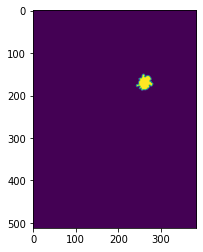

In [73]:
plt.imshow(batch[1][0][2].squeeze())

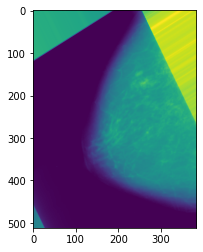

In [74]:
plt.imshow(batch[0][0][2].squeeze())

Stavolta ci serve anche un generatore per i dati di validazione

In [75]:
Validation_data=classes_cae.ValidatorGenerator(X_train_rad_big_val, Y_train_rad_big_val,class_train_rad_big_val,feature_train_big_val,batch_size=batch_dim,shape_tensor=resize_tensor)

In [76]:
batch_2=Validation_data[0]

In [77]:
batch_2[0][0].shape[1:]

(512, 384, 1)

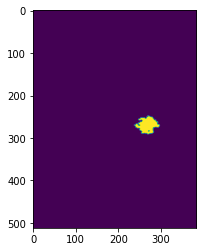

In [78]:
plt.imshow(batch_2[1][0][1].squeeze())

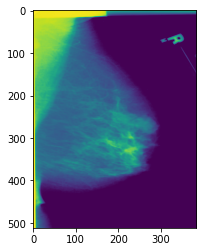

In [79]:
plt.imshow(batch_2[0][0][1].squeeze())

#Define the models with radiomics and bigger dataset

In [80]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [81]:
import keras
import tensorflow as tf
import datetime, os

In [82]:
import tensorflow as tf
model_rad = cae_cnn_models.make_model_rad_big_unet(shape_tensor=batch[0][0].shape[1:],feature_dim=batch[0][1].shape[1:]) 
model_rad.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tensor_input (InputLayer)       [(None, 512, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 512, 384, 16) 160         tensor_input[0][0]               
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 512, 384, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 512, 384, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [83]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [84]:
checkpoint_filepath = '/content/gdrive/big_weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_classification_output_auc',
    mode='max',
    save_best_only=True)

In [85]:
model_rad.compile(optimizer='adam', loss={'decoder_output':'binary_crossentropy','classification_output':'binary_crossentropy'},
                  metrics={'decoder_output':'MAE','classification_output':tf.keras.metrics.AUC()})

In [86]:
epoch_number=5

In [ ]:
history_rad = model_rad.fit(mass_gen_rad_big,steps_per_epoch=len(mass_gen_rad_big), epochs=epoch_number, 
                        validation_data=Validation_data,
                        callbacks=[tensorboard_callback,model_checkpoint_callback])

Epoch 1/5
24/26 [==========================>...] - ETA: 3:29 - loss: 1.2613 - decoder_output_loss: 0.5685 - classification_output_loss: 0.6928 - decoder_output_MAE: 0.4160 - classification_output_auc_1: 0.5661

View on tensorboard

In [ ]:
model_rad.save('/content/drive/MyDrive/BIGUNET_try4')

In [ ]:
%tensorboard --logdir logs

View the results

In [ ]:
caehelper.modelviewer(history_rad)

In [ ]:
model_rad = keras.models.load_model('/content/drive/MyDrive/BIGUNET')

Guardiamo un esempio di output del CAE

In [ ]:
idx=1
xtrain = resize(imread(X_train_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]
ytrain = resize(imread(Y_train_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]

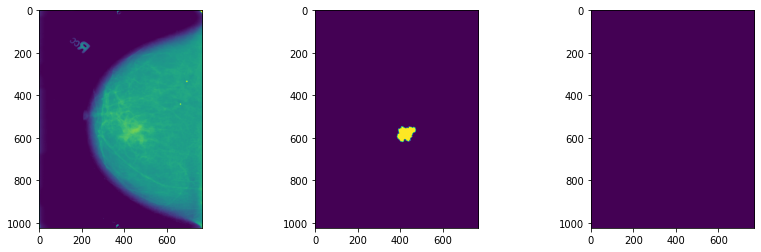

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(xtrain.squeeze())
plt.subplot(1,3,2)
plt.imshow(ytrain.squeeze())
plt.subplot(1,3,3)
plt.imshow(model_rad.predict([xtrain,feature_train_bigg[idx][np.newaxis,...]])[0].squeeze())

Guardiamo un esempio su immagini di test

In [ ]:
idx=16
xtest = resize(imread(X_test_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]
ytest = resize(imread(Y_test_rad_big[idx]),(1024, 768, 1))[np.newaxis,...]

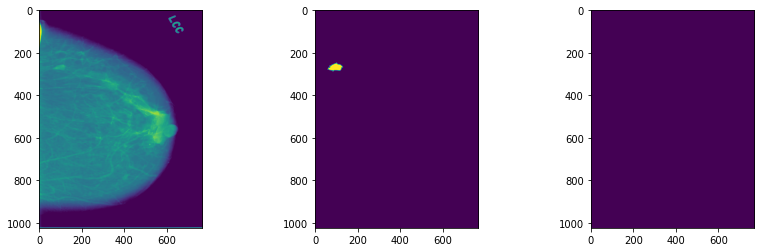

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(xtest.squeeze())
plt.subplot(1,3,2)
plt.imshow(ytest.squeeze())
plt.subplot(1,3,3)
plt.imshow(model_rad.predict([xtest,feature_test_bigg[idx][np.newaxis,...]])[0].squeeze())

In [ ]:
class_train_rad_big[idx],np.argmax(model_rad.predict([xtrain,feature_train_bigg[idx][np.newaxis,...]])[1])

(1, 0)

Calcoliamo il dice medio sul set di test e la curva roc. Per fare ciò definiamo delle versioni parallelizzabili che caricano le immagini direttamente dai path. Dato che le immagini sono grandi e principalmente l'azione è I/O, proviamo a verificare che con il multithreading si ottiene uno speed up.

Dice medio sul test

In [ ]:
dices=[]
def dice_big(list_,k=1,mod=model_rad, shape=(1024,768,1) ,alpha=0.1,lists=dices):
  """calcola il dice di una singola immagine
  :type list_: lista
  :param list_: lista con il path delle immagini e l'array di feature estratte

  :type k: int
  :param k: valore massimo binarizzato della maschera

  :type mod: keras model
  :param mod: modello di keras precedentemente allenato

  :type shape: array
  :param shape: dimensione di resize dell'immagine

  :type alpha: float
  :param alpha: valore di binarizzazione

  :type lists: list
  :param lists: lista vuota da appendere

  :returns: l'indice di dice
  :rtype: float


  """
  pred=resize(imread( str(list_[0])),shape)
  pred=mod.predict([pred[np.newaxis,...],list_[1][np.newaxis,...]])[0].squeeze()>alpha
  true=resize(imread( str(list_[2])),shape).squeeze()
  intersection = np.sum(pred[true==k]) * 2.0

  dice = intersection / (np.sum(pred.squeeze()) + np.sum(true))
  
  lists.append(dice)
  return dice


In [ ]:
listdicer=[]
for i in range(len(X_test_rad_big)):
  listdicer.append([X_test_rad_big[i],feature_test_bigg[i],Y_test_rad_big[i]])

In [ ]:
import concurrent.futures
import time
start=time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.map(dice_big, listdicer)
    print(future)
end=time.perf_counter()
print(f'time elapsed MT: {end-start}')

<generator object Executor.map.<locals>.result_iterator at 0x7f3bf1a5d468>
time elapsed MT: 321.3885523419999


In [ ]:
dices_seq=[]
start=time.perf_counter()
for i in range(len(listdicer)):
  dice_big(listdicer[i],lists=dices_seq) 
end=time.perf_counter()
print(f'time elapsed sequential: {end-start}')

Dunque con una piccola verifica vediamo che il MT ci da un buon speed up di circa un minuto e mezzo.

In [ ]:
dices=np.array(dices)

In [ ]:
dices

In [ ]:
meandice=dices.mean()

In [ ]:
meandice

0.0

Ora la curva roc


In [ ]:
ypred=[]
def ypred_creator(list_,mod=model_rad,list_app=ypred,shape=(1024,768,1)):
  """calcola le predizioni di classificazione
  :type list_: lista
  :param list_: lista con il path delle immagini e l'array di feature estratte

  :type list_app: list
  :param list_app: lista vuota da appendere

  :type shape: array
  :param shape: dimensione di resize dell'immagine

  

  :returns: le probabilità di predizione della classificazione 
  :rtype: list


  """
  x=resize(imread( str(list_[0])),shape)
  y=mod.predict([x[np.newaxis,...],list_[1][np.newaxis,...]])[1][0]
  list_app.append(y)
  return y

In [ ]:
listrocer=[]
for i in range(len(X_test_rad_big)):
  listrocer.append([X_test_rad_big[i],feature_test_bigg[i]])

In [ ]:
start=time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.map(ypred_creator, listrocer)
    print(future)
end=time.perf_counter()
print(f'time elapsed MT: {end-start}')

<generator object Executor.map.<locals>.result_iterator at 0x7f3e07bc45c8>
time elapsed MT: 202.12848428200004


In [ ]:
ypreds_seq=[]
start=time.perf_counter()
for i in range(len(listrocer)):
  ypred_creator(listrocer[i],list_app=ypreds_seq)
end=time.perf_counter()
print(f'time elapsed sequential: {end-start}')

time elapsed sequential: 284.3719415980004


Anche qui abbiamo verificato un speed up di poco più di un minuto. Questo è senz'altro un esempio di azione di GIL.

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(class_test_rad_big, [item[0] for _, item in enumerate(ypred)], pos_label=0)

from sklearn.metrics import auc
auc = auc(fpr, tpr)

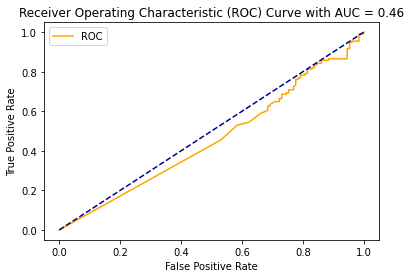

In [ ]:
caehelper.plot_roc_curve(fpr, tpr,auc)


Infine vediamo una Heatmap

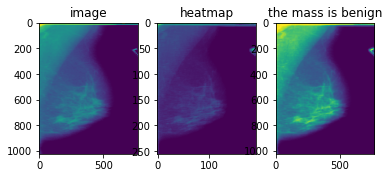

In [ ]:
hmap=caehelper.heatmap_rad(resize(imread(X_test_rad_big[10]),(1024,768)),feature_test_bigg[10],model_rad)